# Titanic Survival Analysis and Machine Learning

### This project is from the Titanic data science competition on Kaggle (https://www.kaggle.com/c/titanic)

This notebook will take a full fledged analysis of the passenger data provided, as well as utilize supervised machine learning techniques to predict survival based on input factors.

Field Legend
- survival	Survival	0 = No, 1 = Yes
- pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	Sex	
- Age	Age in years	
- sibsp	# of siblings / spouses aboard the Titanic	
- parch	# of parents / children aboard the Titanic	
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton



### Import relevant libraries and datasets

In [1]:
# data analysis and wrangling
import pandas as pd

# visualization
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/smcconn5/Portfolio/master/Datasets/Titanic%20Project/train.csv'
                    , error_bad_lines=False) #load train dataset
test = pd.read_csv('https://raw.githubusercontent.com/smcconn5/Portfolio/master/Datasets/Titanic%20Project/test.csv'
                    , error_bad_lines=False) #load test dataset
Titanic = pd.concat([train, test],sort=True) #combine the test and train datasets for a consolidated analysis

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Visual Analytics
Let's start with a visual analysis of some of the metrics. I'll be using Seaborn to create the plots.

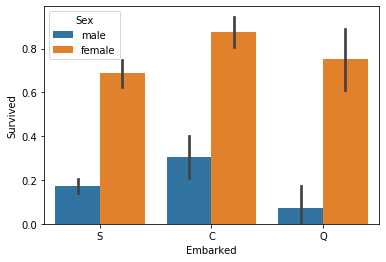

In [3]:
#Since the test dataset doesn't include the survived column, we'll perform a survival analysis on the training dataset
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train); 

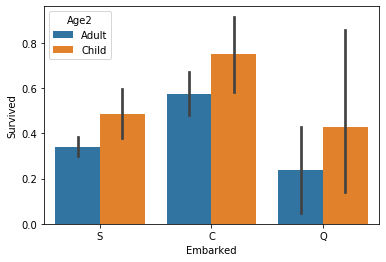

In [4]:
#Since the test dataset doesn't include the survived column, we'll perform a survival analysis on the training dataset
#Let's create a category variable to show if the passenger was a child or not base on the age (less than 18).
train.loc[train['Age'] < 18, 'Age2'] = 'Child' 
train.loc[train['Age'] >= 18, 'Age2'] = 'Adult'
test.loc[test['Age'] < 18, 'Age2'] = 'Child' 
test.loc[test['Age'] >= 18, 'Age2'] = 'Adult' 
sns.barplot(x="Embarked", y="Survived", hue="Age2", data=train);

#### We can see that women's survival rates far exceeded the men's survival rate, which means that passengers onboard the Titanic did in fact abide by the Birkenhead Drill, or Women and Children first.

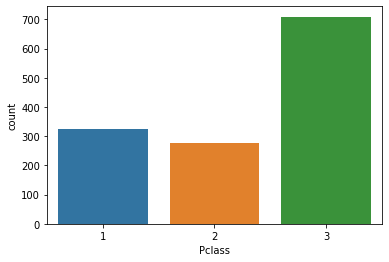

In [5]:
sns.countplot(x="Pclass", data=Titanic)
#Majority of the passengers were third class, the 2nd most passengers were first class
#and the least passengers were second class.

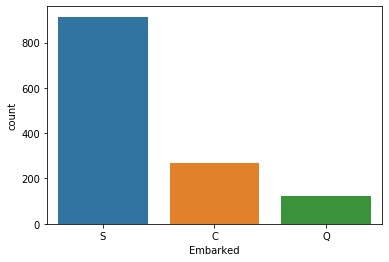

In [6]:
sns.countplot(x="Embarked", data=Titanic)
#Majority of passengers came from Southampton

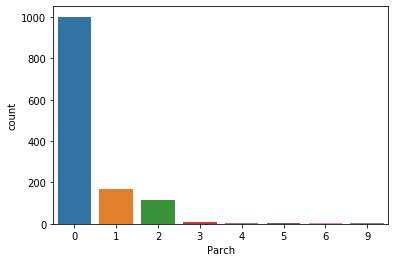

In [7]:
sns.countplot(x="Parch", data=Titanic)
#Majority of passengers were travelling without parents or children

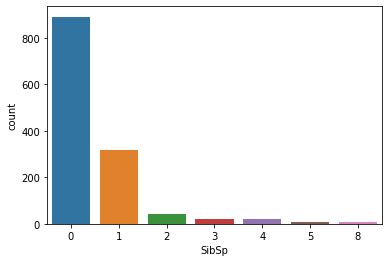

In [8]:
sns.countplot(x="SibSp", data=Titanic)
#Majority of passengers were travelling without siblings and spouses

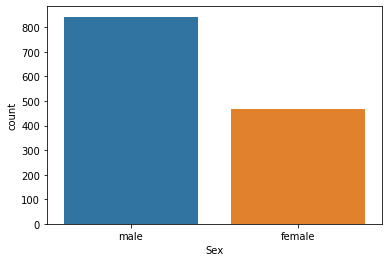

In [9]:
sns.countplot(x="Sex", data=Titanic)
#Majority of passengers were male

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

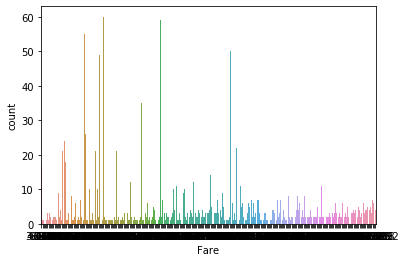

In [10]:
sns.countplot(x="Fare", data=Titanic)
Titanic['Fare'].describe()
#There's a wide range of fares that were paid, with the highest being a hefty $512. Inspecting the plot below shows that the
#majority of passengers had a fare of ~$15 or less.

### Data wrangling and correction
Let's actually inspect the data and see if there's anything we need to correct before beginning the machine learning procedures.

In [11]:
print(train.shape)
print(test.shape)
print(Titanic.shape)
print(train.info())
print(test.info())
#There's a significant number of missing cabin numbers. Age is also problematic because it's missing almost 200 observations.
#Embarked is only missing 2 observations
#We're missing a few age and 1 fare in the test data as well. We'll have to impute those as well.

(891, 13)
(418, 12)
(1309, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Age2           714 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int

In [12]:
#To correct for age, we'll replace the null values with the mean age of the passengers.
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())
#Since we replaced the null values with the mean age, we'll need to reassess the child/adult transformation from above
train.loc[train['Age'] < 18, 'Age2'] = 'Child' 
train.loc[train['Age'] >= 18, 'Age2'] = 'Adult' 
test.loc[test['Age'] < 18, 'Age2'] = 'Child' 
test.loc[test['Age'] >= 18, 'Age2'] = 'Adult'
#To correct for cabin, we'll make a judgement call and replace the null values with 'S' since most passengers came from Southampton
train['Embarked'] = train['Embarked'].fillna('S')
#To correct for fare in the test set, we'll replace the null value with the mean fare.
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())


#As much as I would love to correct the cabin data, there's no good way to replace the null values. 
del train['Cabin']
del test['Cabin']
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Age2           891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null 

#### Let's change some of these categorical variables into numerical to boost the performance of the models.

In [13]:
train['Sex'].replace('female', 0, inplace=True)
train['Sex'].replace('male', 1, inplace=True)
test['Sex'].replace('female', 0, inplace=True)
test['Sex'].replace('male', 1, inplace=True)

train.loc[train['Embarked'] == 'S', 'Southampton'] = 1 
train.loc[train['Embarked'] != 'S', 'Southampton'] = 0
train.loc[train['Embarked'] == 'Q', 'Queenstown'] = 1 
train.loc[train['Embarked'] != 'Q', 'Queenstown'] = 0
test.loc[train['Embarked'] == 'S', 'Southampton'] = 1 
test.loc[train['Embarked'] != 'S', 'Southampton'] = 0
test.loc[train['Embarked'] == 'Q', 'Queenstown'] = 1 
test.loc[train['Embarked'] != 'Q', 'Queenstown'] = 0
train.loc[train['Embarked'] == 'C', 'Cherbourg'] = 1 
train.loc[train['Embarked'] != 'C', 'Cherbourg'] = 0
test.loc[train['Embarked'] == 'C', 'Cherbourg'] = 1 
test.loc[train['Embarked'] != 'C', 'Cherbourg'] = 0

train['Age2'].replace('Child', 0, inplace=True)
train['Age2'].replace('Adult', 1, inplace=True)
test['Age2'].replace('Child', 0, inplace=True)
test['Age2'].replace('Adult', 1, inplace=True)

#### Let's change the SibSp and Parch fields. By combining them and adding 1 to account for the passenger, we can calculate the family size

In [14]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

train = train.drop(['SibSp','Parch', 'Embarked', 'Ticket', 'Name','PassengerId'], axis=1)
test = test.drop(['SibSp','Parch','Embarked', 'Ticket', 'Name'], axis=1)

train.head()

,Survived,Pclass,Sex,Age,Fare,Age2,Southampton,Queenstown,Cherbourg,FamilySize
0,0,3,1,22.0,7.2500,1,1.0,0.0,0.0,2
1,1,1,0,38.0,71.2833,1,0.0,0.0,1.0,2
2,1,3,0,26.0,7.9250,1,1.0,0.0,0.0,1
3,1,1,0,35.0,53.1000,1,1.0,0.0,0.0,2
4,0,3,1,35.0,8.0500,1,1.0,0.0,0.0,1


In [15]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Age2,Southampton,Queenstown,Cherbourg,FamilySize
0,892,3,1,34.5,7.8292,1,1.0,0.0,0.0,1
1,893,3,0,47.0,7.0000,1,0.0,0.0,1.0,2
2,894,2,1,62.0,9.6875,1,1.0,0.0,0.0,1
3,895,3,1,27.0,8.6625,1,1.0,0.0,0.0,1
4,896,3,0,22.0,12.2875,1,1.0,0.0,0.0,3


#### Now that the variables are setup to be numeric, let's look at a correlation of the data to see which variables are significant

In [16]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Sex,Age,Fare,Age2,Southampton,Queenstown,Cherbourg,FamilySize
Survived,1,-0.338481,-0.543351,-0.0698085,0.257307,-0.122239,-0.149683,0.00365038,0.16824,0.016639
Pclass,-0.338481,1,0.1319,-0.331339,-0.5495,-0.12562,0.0740528,0.221009,-0.243292,0.0659969
Sex,-0.543351,0.1319,1,0.0841534,-0.182333,0.10715,0.119224,-0.0741151,-0.0828535,-0.200988
Age,-0.0698085,-0.331339,0.0841534,1,0.0915661,0.605852,-0.0193356,-0.0138552,0.0320244,-0.248512
Fare,0.257307,-0.5495,-0.182333,0.0915661,1,0.00754621,-0.162184,-0.117216,0.269335,0.217138
Age2,-0.122239,-0.12562,0.10715,0.605852,0.00754621,1,-0.000542565,0.0331936,-0.0232251,-0.380192
Southampton,-0.149683,0.0740528,0.119224,-0.0193356,-0.162184,-0.000542565,1,-0.499421,-0.782742,0.0773585
Queenstown,0.00365038,0.221009,-0.0741151,-0.0138552,-0.117216,0.0331936,-0.499421,1,-0.148258,-0.0585921
Cherbourg,0.16824,-0.243292,-0.0828535,0.0320244,0.269335,-0.0232251,-0.782742,-0.148258,1,-0.0462153
FamilySize,0.016639,0.0659969,-0.200988,-0.248512,0.217138,-0.380192,0.0773585,-0.0585921,-0.0462153,1


## Modeling

Since we're trying to predict survival or not (yes or no), this is a  logistic regression and classification problem. 

- Logistic Regression
- k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forest

In [17]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [18]:
# Logistic Regression

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
con_log = round(logreg.score(X_train, Y_train) * 100, 2)
con_log

#Produces confidence of 80.58%

80.58

In [19]:
# Support Vector Machines

svc = SVC(gamma='auto')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
con_svc = round(svc.score(X_train, Y_train) * 100, 2)
con_svc

#Produces confidence of 87.77%

87.77

In [20]:
#KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
con_knn = round(knn.score(X_train, Y_train) * 100, 2)
con_knn

#Produces confidence of 83.61%

83.61

In [21]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
con_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
con_gaussian

#Produces confidence of 79.8$

79.8

In [22]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
con_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
con_linear_svc

#Produces confidence of 70.82%

C:\Users\sean_\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


78.11

In [23]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
con_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
con_decision_tree

#Produces confidence of 98.2%

98.2

In [24]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
con_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
con_random_forest

#Produces confidence of 98.2%

98.2

In [25]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree'],
    'Score': [con_svc, con_knn, con_log, 
              con_random_forest, con_gaussian, 
            con_linear_svc, con_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.20
6,Decision Tree,98.20
0,Support Vector Machines,87.77
1,KNN,83.61
2,Logistic Regression,80.58
4,Naive Bayes,79.80
5,Linear SVC,78.11


In [28]:
Test_Predictions = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": decision_tree.predict(X_test)
    })
print(Test_Predictions)

     PassengerId  Survived
0            892         0
1            893         0
2            894         1
3            895         1
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


### Conclusion
All of our models are great predictors, but Random Forest and Decision Tree produced the best confidence score with 98.2%.